In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random

# GPU Check
print("TensorFlow Version:", tf.__version__)

# Image Settings
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
dataset_path = 'veriseti' # Klasör adın aynı kalsın

TensorFlow Version: 2.19.0


In [3]:
print("Preparing data...")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,       
    width_shift_range=0.2,   
    height_shift_range=0.2,
    shear_range=0.2,         
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest',
    validation_split=0.2     
)

# Training Set
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Set
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False 
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes found: {class_names}")

Preparing data...
Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Classes found: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [5]:
# Compute Class Weights to handle imbalance
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights (Higher value means higher priority): {class_weights_dict}")

Class Weights (Higher value means higher priority): {0: 1.0156438026474128, 1: 0.9601820250284414, 2: 1.0471464019851116, 3: 0.9813953488372092}


In [7]:
# 1. Download VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# 2. Deep Fine-Tuning Strategy
# Unfreeze the last 8 layers
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# 3. Add Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x) 
x = Dropout(0.5)(x)      
output = Dense(4, activation='softmax')(x)

# 4. Create Model
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Enhanced Model is Ready!")
model.summary()

Enhanced Model is Ready!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,564,356 (105.15 MB)

 Trainable params: 25,827,844 (98.53 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [9]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

print("Training Starting... (Max 25 Epochs)")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=25, 
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights_dict 
)

# Save Model
model.save('eye_disease_final_model.h5')
print("Training Complete. Model Saved!")

Training Starting... (Max 25 Epochs)


C:\Users\celeb\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - accuracy: 0.4514 - loss: 1.4742 - val_accuracy: 0.5805 - val_loss: 0.9899 - learning_rate: 1.0000e-05
Epoch 2/25
  1/105 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 0.6250 - loss: 1.1966

C:\Users\celeb\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 502ms/step - accuracy: 0.6250 - loss: 1.1966 - val_accuracy: 0.5565 - val_loss: 1.0096 - learning_rate: 1.0000e-05
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.6761 - loss: 0.8899 - val_accuracy: 0.6947 - val_loss: 0.8033 - learning_rate: 1.0000e-05
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - accuracy: 0.7812 - loss: 0.7810 - val_accuracy: 0.6851 - val_loss: 0.8055 - learning_rate: 1.0000e-05
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.7735 - loss: 0.6381 - val_accuracy: 0.7067 - val_loss: 0.7416 - learning_rate: 1.0000e-05
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - accuracy: 0.8125 - loss: 0.6116 - val_accuracy: 0.6995 - val_loss: 0.7711 - learning_rate: 1.0000e-05
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.7703 - loss: 0.6005 - val_accuracy: 0.7500 - val_loss: 0.6973 - learning_rate: 1.0000e-05
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 534ms/step - accura

Training Complete. Model Saved!


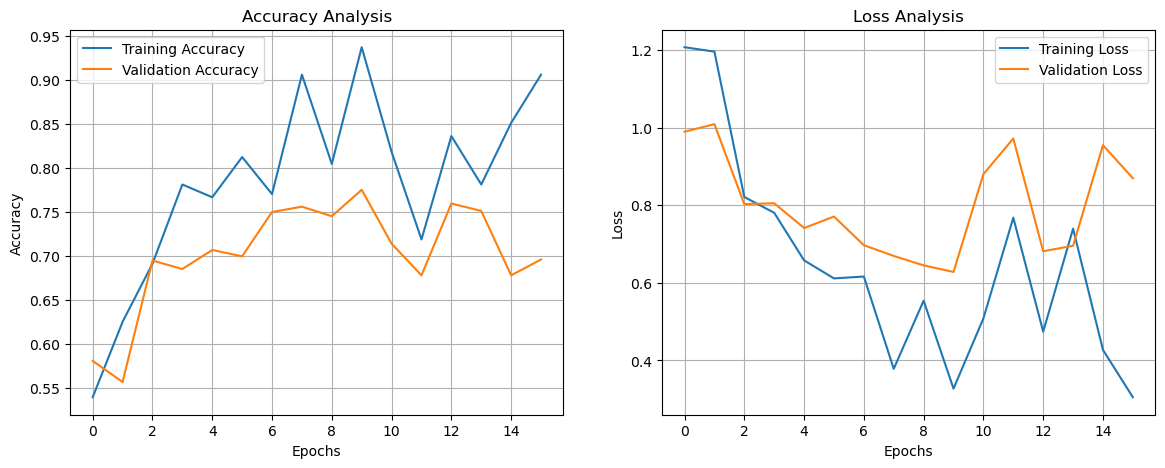

In [11]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Analysis')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Analysis')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Found 841 images belonging to 4 classes.
Running analysis on validation set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step


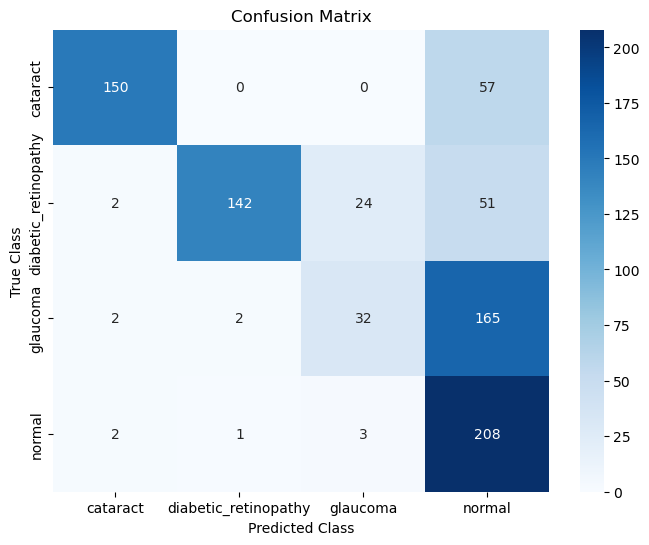

CLASSIFICATION REPORT
------------------------------
                      precision    recall  f1-score   support

            cataract       0.96      0.72      0.83       207
diabetic_retinopathy       0.98      0.65      0.78       219
            glaucoma       0.54      0.16      0.25       201
              normal       0.43      0.97      0.60       214

            accuracy                           0.63       841
           macro avg       0.73      0.63      0.61       841
        weighted avg       0.73      0.63      0.62       841



In [13]:
# Reload validation data without shuffling
val_gen_no_shuffle = ImageDataGenerator(rescale=1./255, validation_split=0.2).flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False 
)

# Predict
print("Running analysis on validation set...")
Y_pred = model.predict(val_gen_no_shuffle, val_gen_no_shuffle.samples // 32 + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen_no_shuffle.classes[:len(y_pred)]

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("CLASSIFICATION REPORT")
print("-" * 30)
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


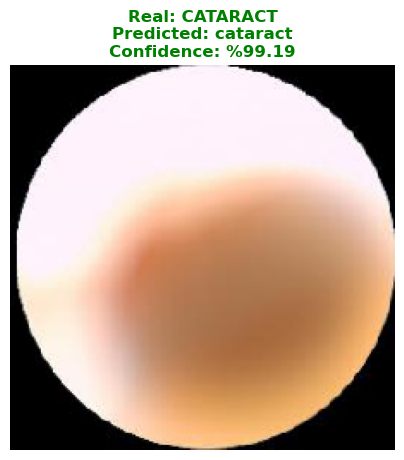

In [15]:
from tensorflow.keras.preprocessing import image

# Target Class for testing
target_class = 'cataract' 

# Path handling
base_folder = os.path.join(dataset_path, target_class)
if os.path.exists(os.path.join(base_folder, target_class)):
    test_folder = os.path.join(base_folder, target_class)
else:
    test_folder = base_folder

# Pick Random Image
all_files = os.listdir(test_folder)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if image_files:
    random_image = random.choice(image_files)
    img_path = os.path.join(test_folder, random_image)

    # Preprocess
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = np.max(predictions) * 100

    # Display Result
    color = 'green' if target_class in predicted_class.lower() or (target_class=='normal' and 'normal' in predicted_class.lower()) else 'red'
    
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Real: {target_class.upper()}\nPredicted: {predicted_class}\nConfidence: %{confidence:.2f}", color=color, fontweight='bold')
    plt.axis('off')
    plt.show()
else:
    print("Image not found in directory!")